Hannah Diamond-Lowe is working on LTT 1445A and GJ486. Big problems in the optical.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [5]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/'
sx1s = np.hstack((glob.glob('{}ltt1445A/stis/*sx1.fits'.format(path)), glob.glob('{}gj486/stis/*sx1.fits'.format(path)) ))
sx1s

array(['/media/david/2tb_ext_hd/hddata/meats/hst/ltt1445A/stis/oeoo01040_sx1.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj486/stis/oeoo02040_sx1.fits'],
      dtype='<U73')

/media/david/2tb_ext_hd/hddata/meats/hst/ltt1445A/stis/oeoo01040_sx1.fits
G430L
[894.76685]
/media/david/2tb_ext_hd/hddata/meats/hst/gj486/stis/oeoo02040_sx1.fits
G430L
[894.562]


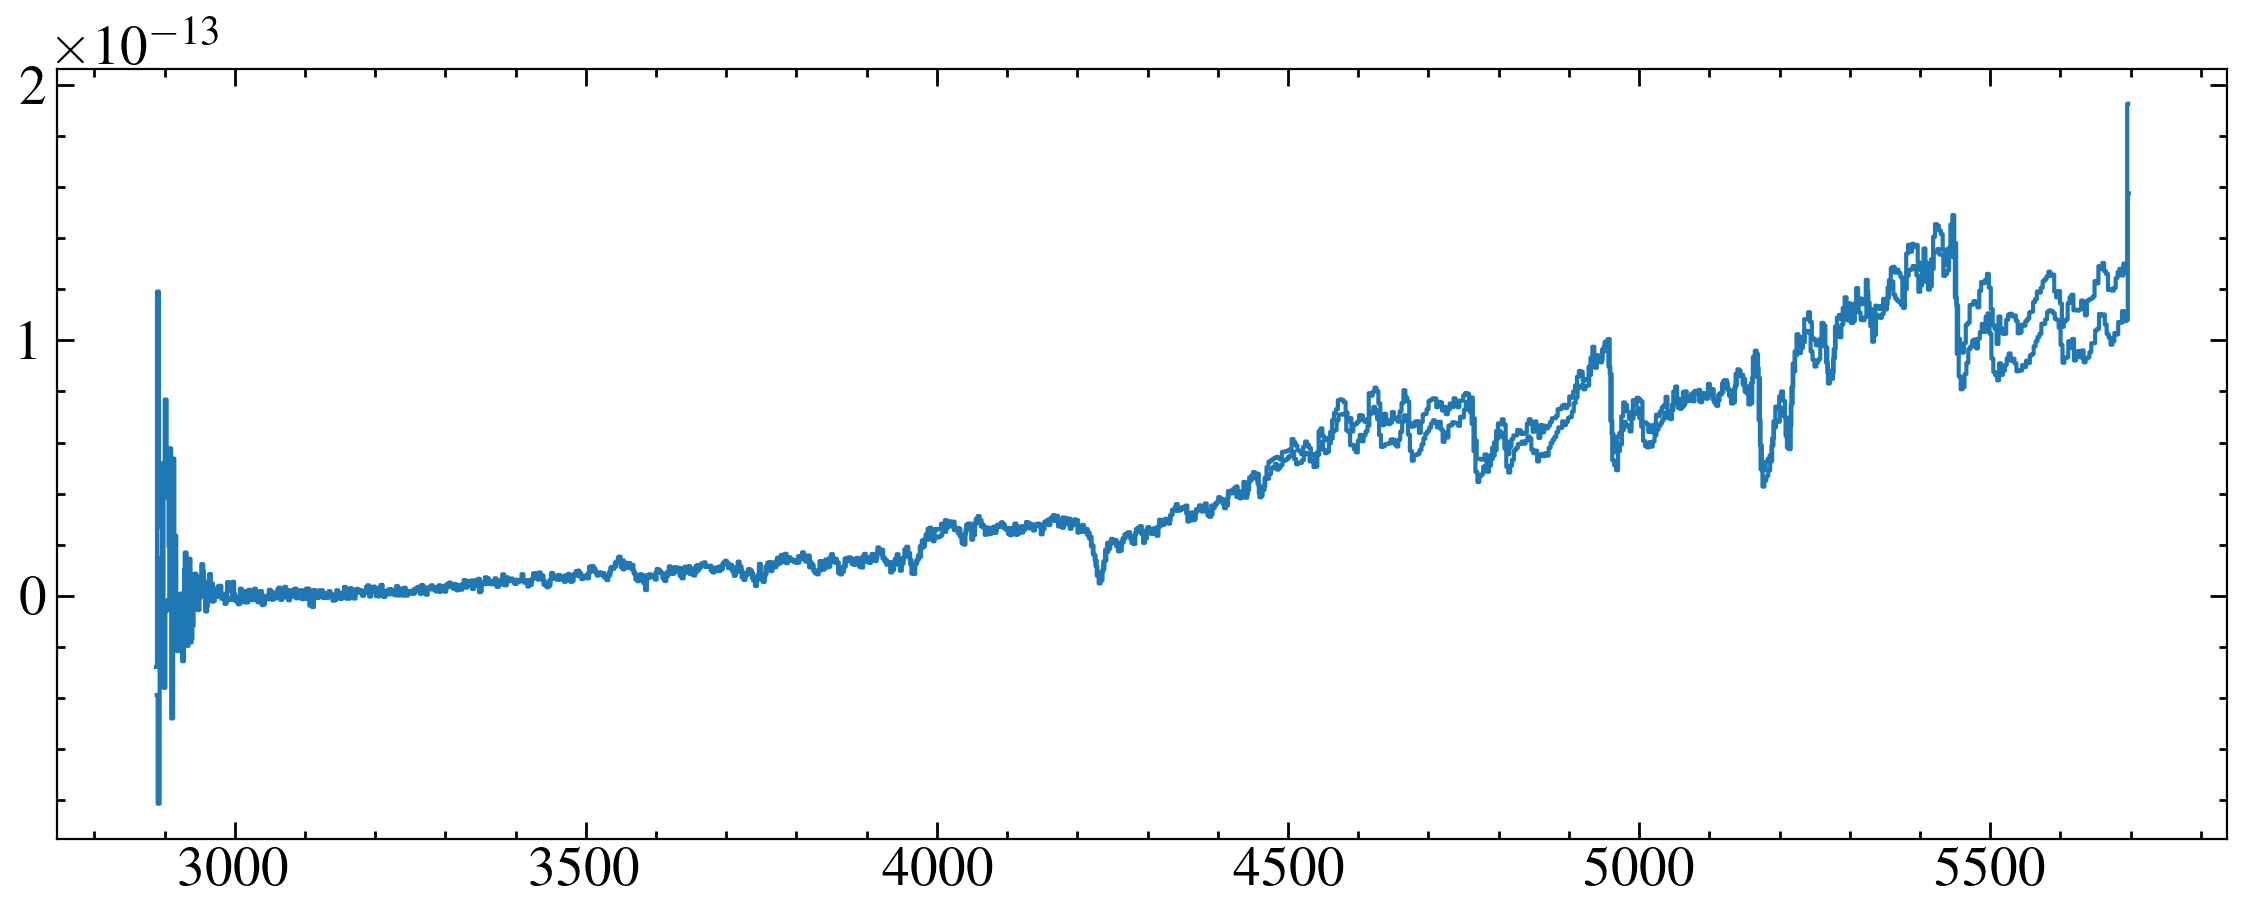

In [9]:
for x in sx1s:
    print(x)
    print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = w > 1160
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid', c='C0')
    # plt.step(w, e, where='mid', c='C1')
    # plt.show()

In [10]:
import importlib
import prepare_phoenix_svo as pp
importlib.reload(pp)

<module 'prepare_phoenix_svo' from '/home/david/work/meats/SEDs/prepare_phoenix_svo.py'>

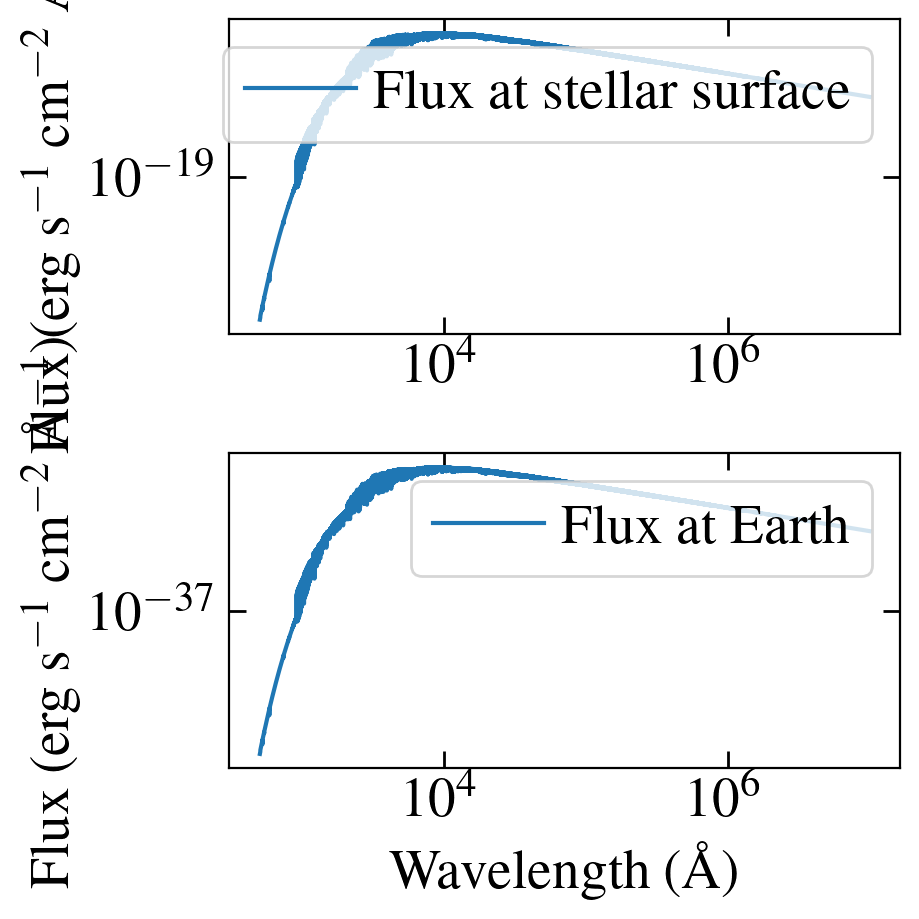

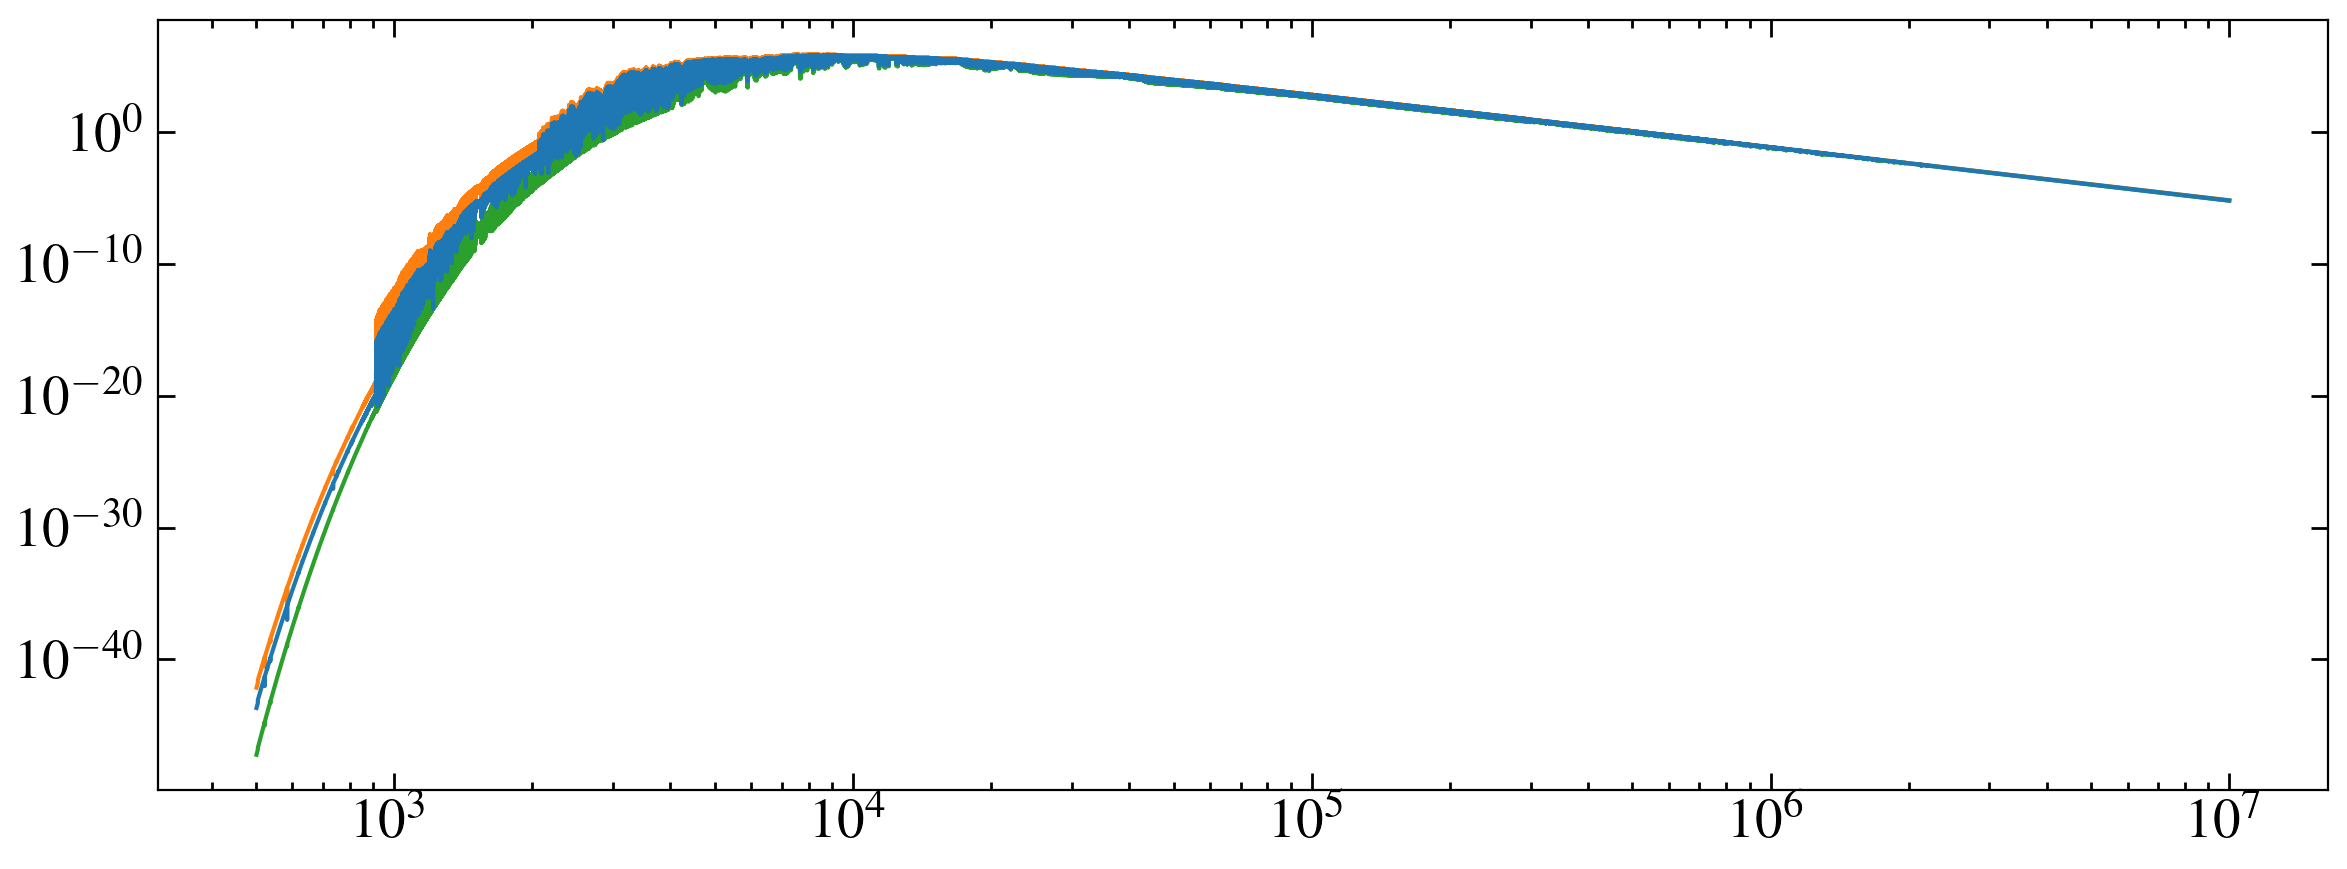

In [11]:


G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 0.454
teff = 3337
teff_e = 150

radius = 0.276
distance = 6.86

save_path = 'models/'
star = 'LTT1445A'
# g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
g = 4.967
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'Teff_e':teff_e,  'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
# pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=True, make_error=True)
pdata = Table.read('models/{}_phoenix_interpolated.ecsv'.format(star))
lpw, lpf, lpe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
lnormfac = ((radius*R)/((distance*u.pc).to(u.m)))**2

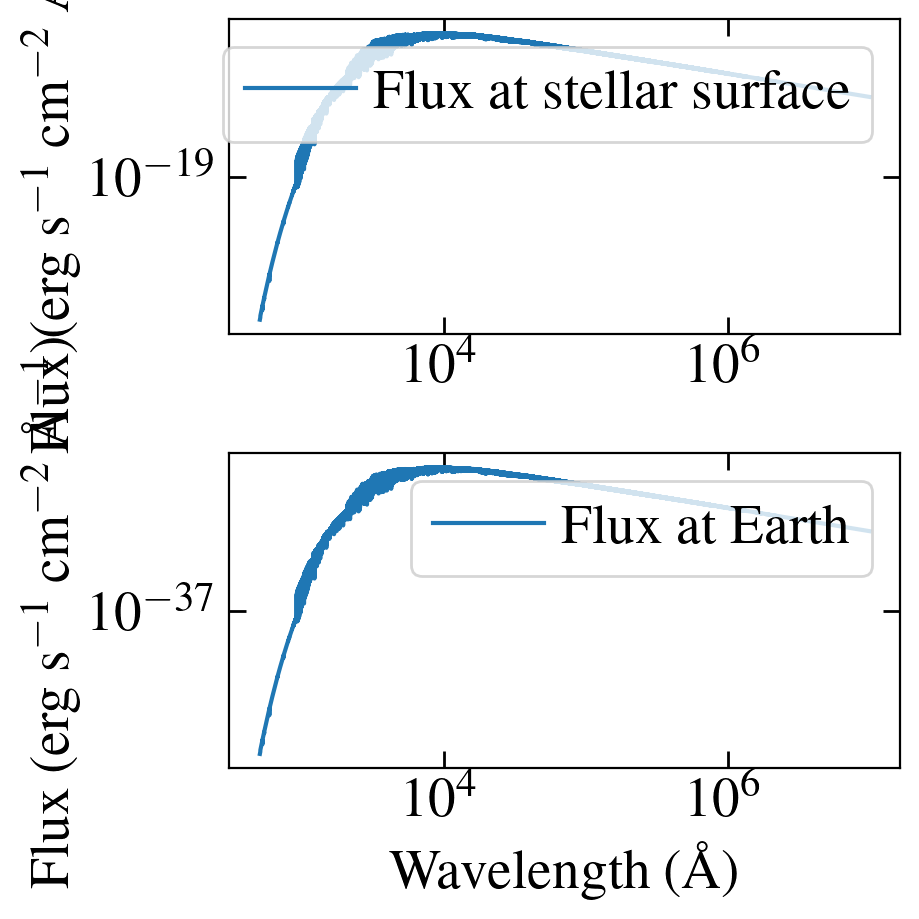

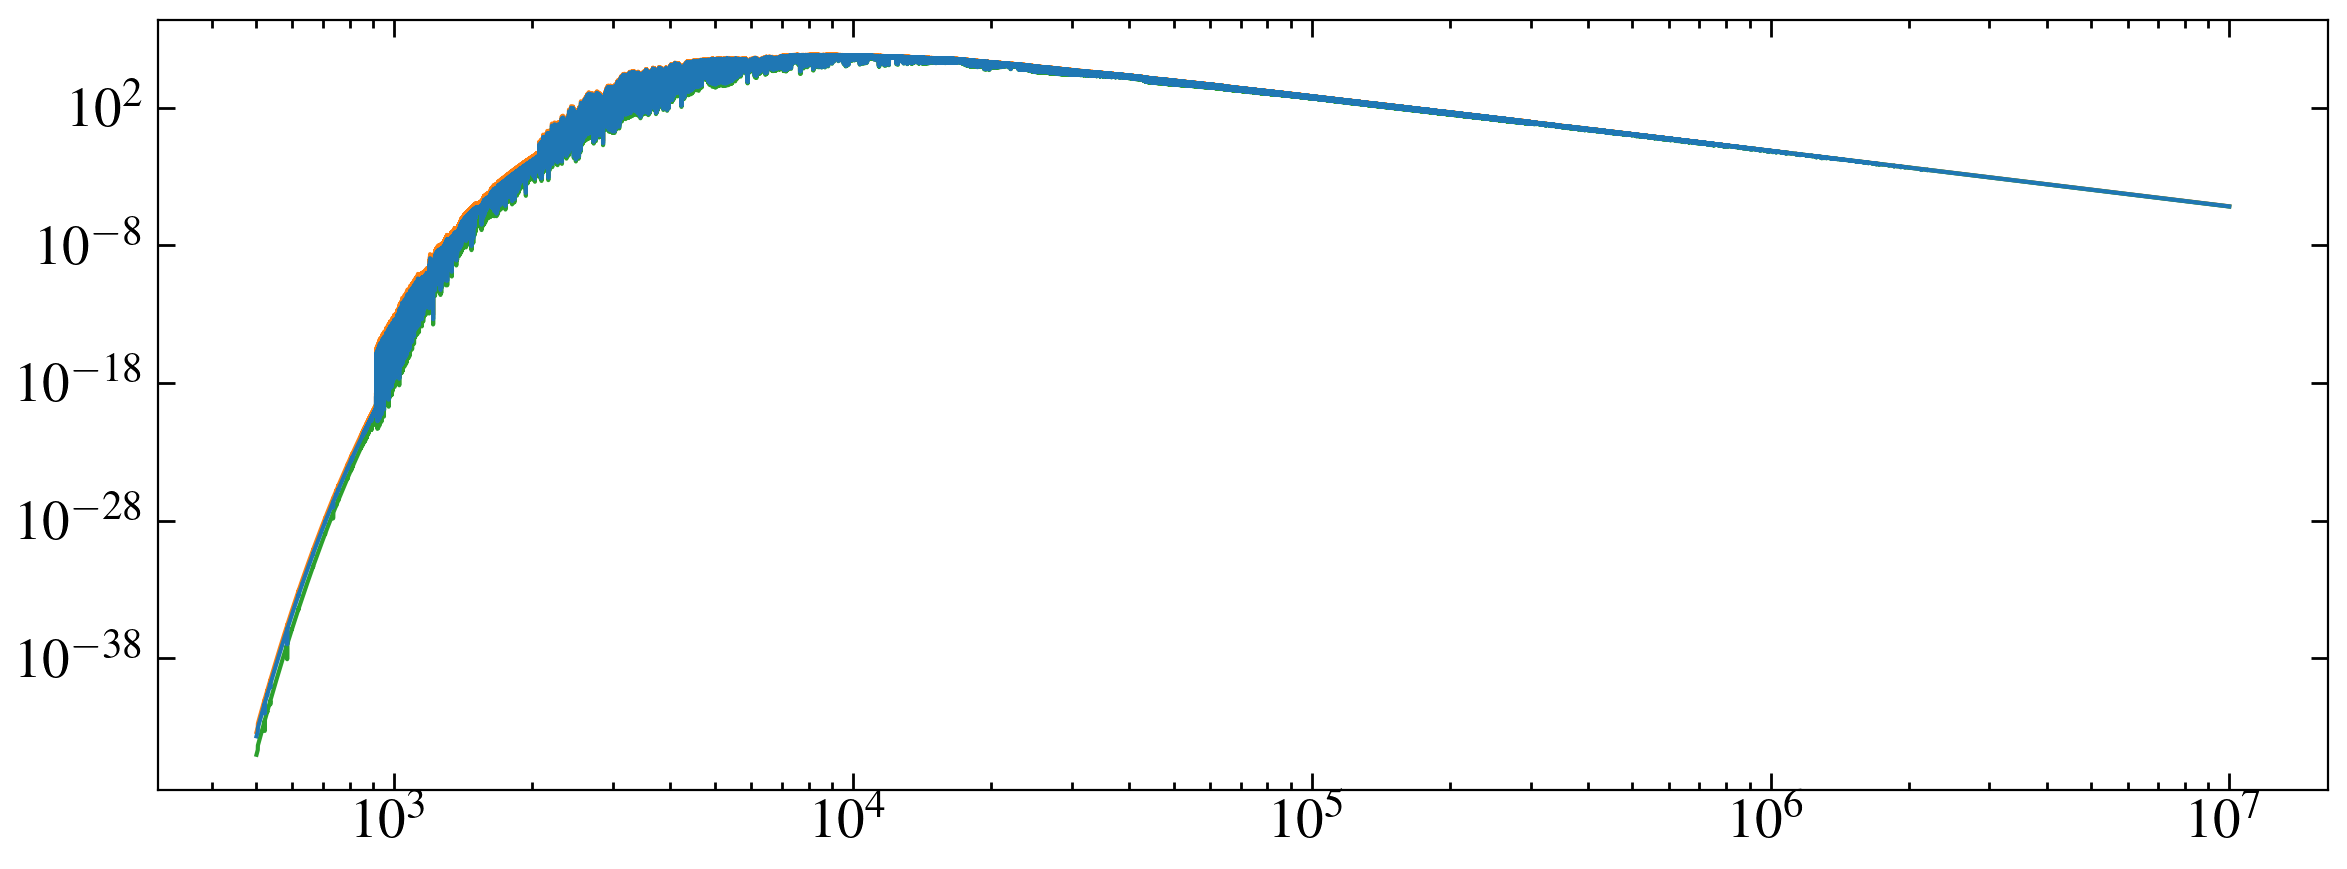

In [12]:
G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 0.323
teff = 3340
teff_e = 54

radius = 0.328
distance = 8.08

save_path = 'models/'
star = 'GJ486'
# g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
g = 4.91
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'Teff_e':teff_e,  'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
# pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=True, make_error=True)
pdata = Table.read('models/{}_phoenix_interpolated.ecsv'.format(star))
gpw, gpf, gpe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
gnormfac = ((radius*R)/((distance*u.pc).to(u.m)))**2

In [14]:
pws = [lpw, gpw]
pfs = [lpf, gpf]
norms = [lnormfac, gnormfac]

BD-17-588A


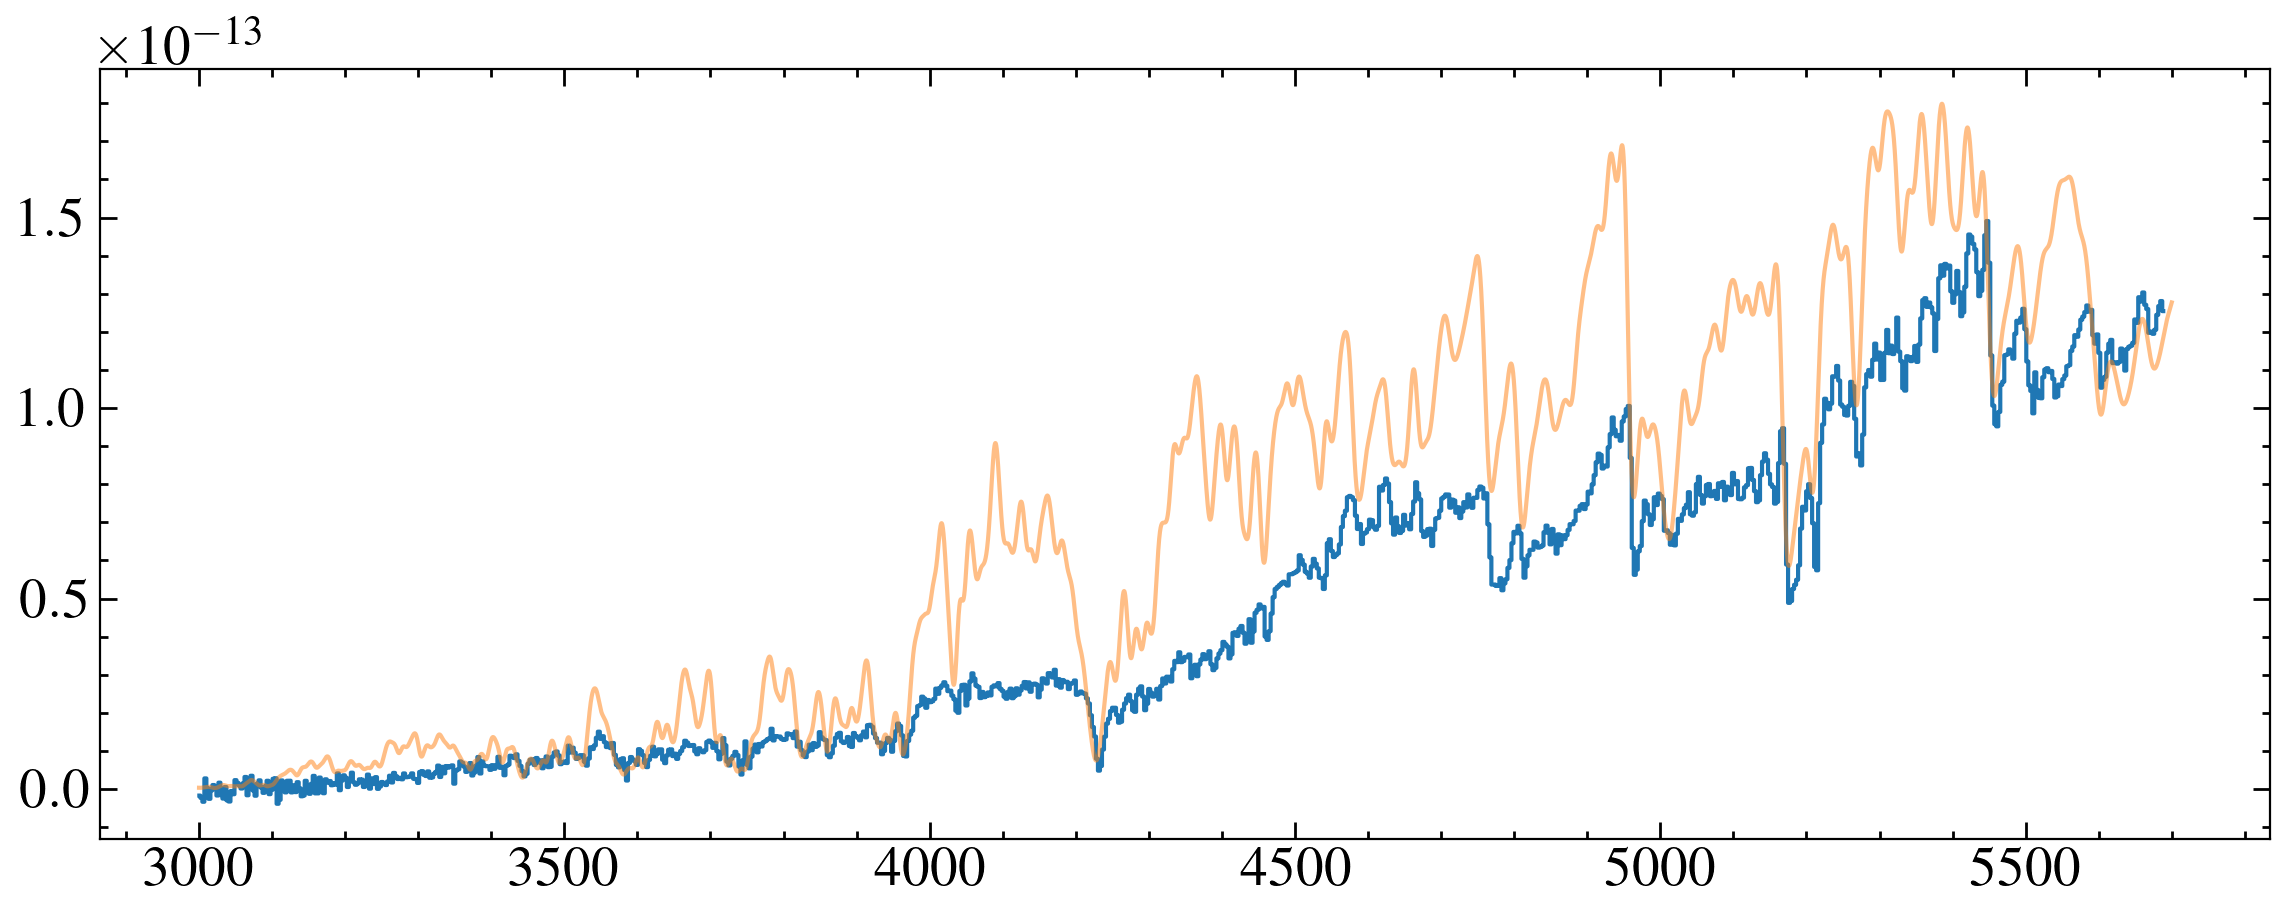

WOLF-437


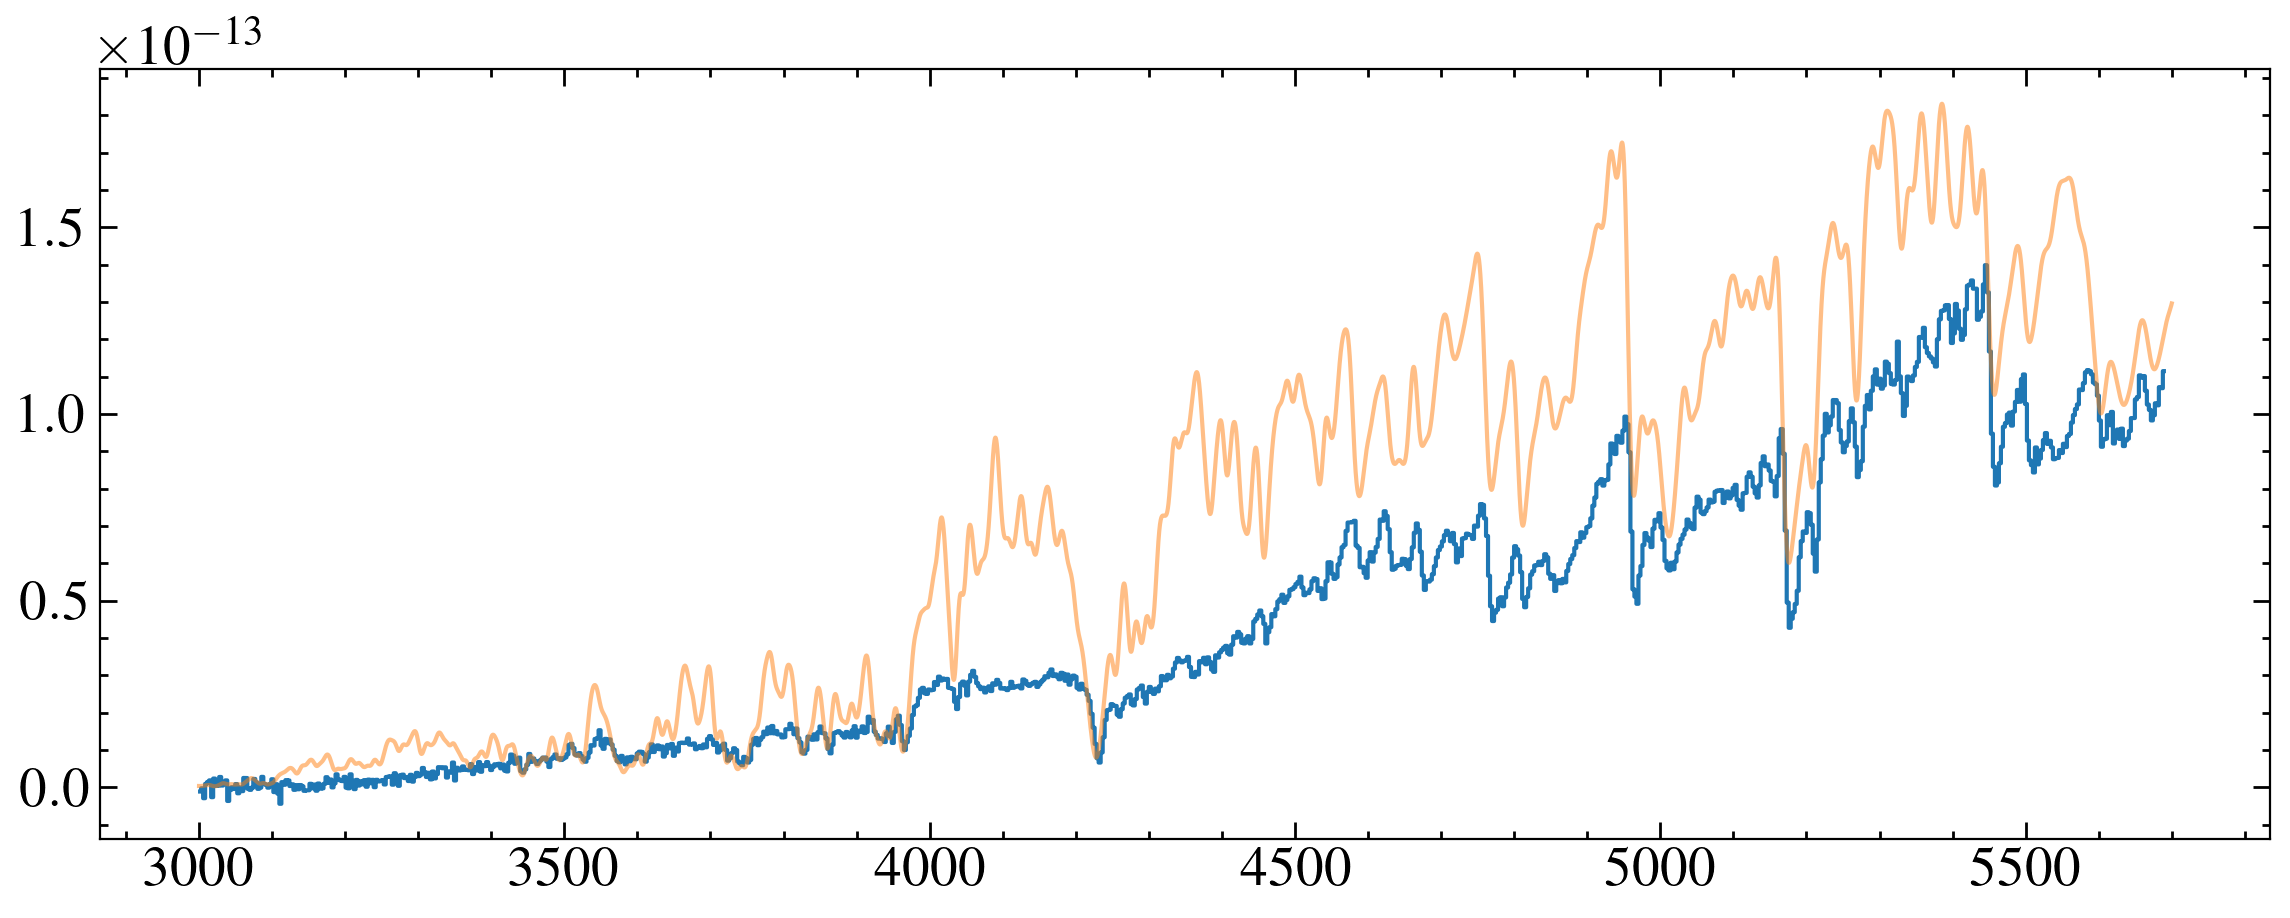

In [28]:
for i, x in enumerate(sx1s):
    fig, ax = plt.subplots()
    print(fits.getheader(x, 0)['TARGNAME'])

    data = fits.getdata(x, 1)
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = (w > 3000) & (w < 5690)
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid', c='C0')
  
    
    pw, pf, normfac = pws[i], pfs[i], norms[i]
    pw, pf = pp.smear(pw, pf,1000)
    pmask = (pw > 3000) & (pw < 5700)
    pwi, pfi = pw[pmask], pf[pmask]*normfac
    ax.plot(pwi, pfi, alpha=0.5, c='C1')

    plt.show()

Ok obvious problems. Can we find more data? Gaia XP spectra?

In [33]:
# gaia = Table.read('data/wolf1120_gaia_spectrum.vot')
# mask = gaia['type'] == 'XP'
# ax.plot(gaia['wavelength'][mask]*10, gaia['flux'][mask]*(u.W/u.m**2/u.nm).to(u.erg/u.s/u.cm**2/u.AA), 
#            label = 'Gaia XP spectrum', c='C0', lw=2)

# gw, gf = gaia['wavelength'][mask]*10, gaia['flux'][mask]*(u.W/u.m**2/u.nm).to(u.erg/u.s/u.cm**2/u.AA)

gaia_specs = ['misc_data/hdl_gaia/ltt1445A_gaiadr3_sampled_mean_spectra_5153091836072107136.vot',
       'misc_data/hdl_gaia/gj486_gaiadr3_sampled_mean_spectra_3735000631158990976.vot']

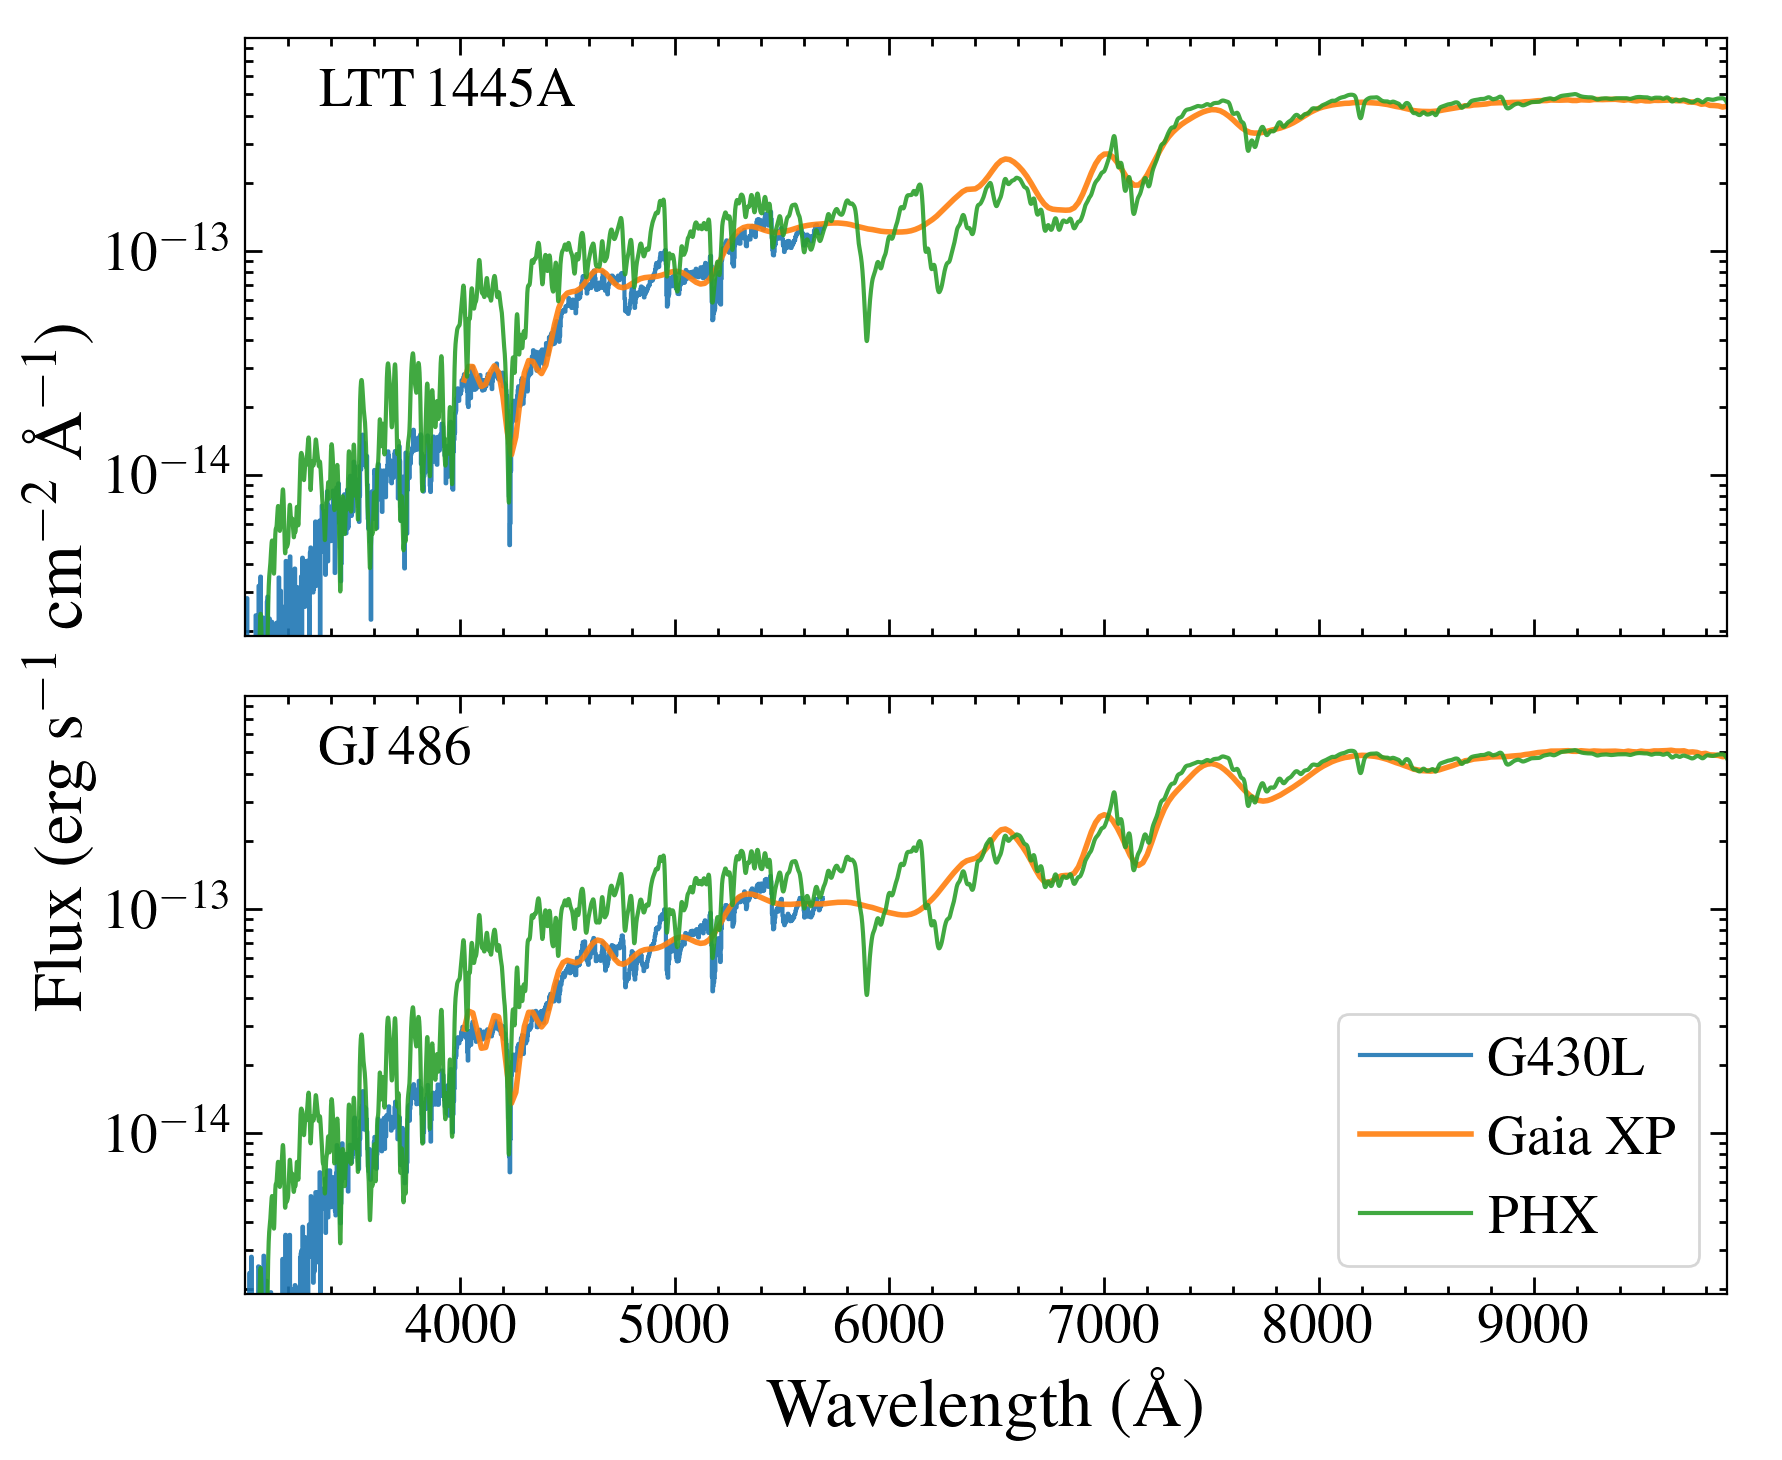

In [97]:
stars = ['LTT\,1445A', 'GJ\,486']

fig, axes = plt.subplots(nrows=2, figsize=(10, 8), sharex=True, sharey=True)
for i, x in enumerate(sx1s):
    ax = axes[i]
    # fig, ax = plt.subplots()
    # print(fits.getheader(x, 0)['TARGNAME'])

    data = fits.getdata(x, 1)
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = (w > 3000) & (w < 5690)
    w, f, e = w[mask], f[mask], e[mask]
    ax.step(w, f, where='mid', c='C0', label='G430L', alpha=0.9)
  
    


    gaia = Table.read(gaia_specs[i])
    mask = gaia['type'] == 'XP'
    gw, gf = gaia['wavelength'][mask]*10, gaia['flux'][mask]*(u.W/u.m**2/u.nm).to(u.erg/u.s/u.cm**2/u.AA)
    mask = (gw > 4000) #& (gw < 1000)
    gw, gf = gw[mask], gf[mask]
    ax.plot(gw, gf, c='C1', label ='Gaia XP', alpha=0.9, lw=2)

    pw, pf, normfac = pws[i], pfs[i], norms[i]
    pw, pf = pp.smear(pw, pf,1000)
    pmask = (pw > 3000) & (pw < 10000)
    pwi, pfi = pw[pmask], pf[pmask]*normfac
    ax.plot(pwi, pfi, alpha=0.9, c='C2', label = 'PHX')

    # ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_ylim(1.9e-15, 8.9e-13)
    ax.set_xlim(3001, 9899)
    
    ax.annotate(stars[i], (0.05, 0.95), xycoords='axes fraction', ha='left', va='top')

axes[1].legend(loc =4, frameon=True)
    
bigax = fig.add_subplot(111, frame_on=False)
bigax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
bigax.set_xlabel('Wavelength (\AA)', size=25)
bigax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=25, labelpad=25)

fig.tight_layout()
# fig.subplots_adjust(wspace=0.03, bottom=0.15, left=0.09, right=0.99)

# fig.savefig('plots/ltt1445A_gj486_opticalspectra_.pdf')
    # plt.show()